In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import urllib.request
import matplotlib.pyplot as plt

In [32]:
list_metricas = ['average_clustering', 'coefficient_distribution_degree', 'density', 'average_degree', 'average_short_path']#, 'number_of_nodes']
#list_metricas = ['coefficient_distribution_degree']

list_variables = [
    'Valor_Ativo',
    'Patrimonio_Liquido',
    'Cotas_Emitidas',
    'Valor_Patrimonial_Cotas',
    'Percentual_Despesas_Taxa_Administracao',
    'Percentual_Despesas_Agente_Custodiante',
    'Percentual_Rentabilidade_Efetiva_Mes',
    'Percentual_Rentabilidade_Patrimonial_Mes',
    'Percentual_Dividend_Yield_Mes',
    'Percentual_Amortizacao_Cotas_Mes',
    'Total_Necessidades_Liquidez',
    'Disponibilidades',
    'Titulos_Publicos',
    'Titulos_Privados',
    'Fundos_Renda_Fixa',
    'Total_Investido',
    'Direitos_Bens_Imoveis',
    'Terrenos',
    'Imoveis_Renda_Acabados',
    'Imoveis_Renda_Construcao',
    'Imoveis_Venda_Acabados',
    'Imoveis_Venda_Construcao',
    'Outros_Direitos_Reais',
    'Acoes',
    'Debentures',
    'Bonus_Subscricao',
    'Certificados_Deposito_Valores_Mobiliarios',
    'Cedulas_Debentures',
    'Fundo_Acoes',
    'FIP',
    'FII',
    'FDIC',
    'Outras_Cotas_FI',
    'Notas_Promissorias',
    'Acoes_Sociedades_Atividades_FII',
    'Cotas_Sociedades_Atividades_FII',
    'CEPAC',
    'CRI',
    'Letras_Hipotecarias',
    'LCI',
    'LIG',
    'Outros_Valores_Mobliarios',
    'Valores_Receber',
    'Contas_Receber_Aluguel',
    'Contas_Receber_Venda_Imoveis',
    'Outros_Valores_Receber',
    'Rendimentos_Distribuir',
    'Taxa_Administracao_Pagar',
    'Taxa_Performance_Pagar',
    'Obrigacoes_Aquisicao_Imoveis',
    'Adiantamento_Venda_Imoveis',
    'Adiantamento_Alugueis',
    'Obrigacoes_Securitizacao_Recebiveis',
    'Instrumentos_Financeiros_Derivativos',
    'Provisoes_Contigencias',
    'Outros_Valores_Pagar',
    'Total_Passivo',
 ]

list_cat = [
    'Mandato',
    'Segmento_Atuacao',
    #'Publico_Alvo',
    #'Tipo_Gestao',
]

ds_fii = xr.open_dataset('dataset/cvm/dataset_cvm_metrica_mensal.nc').fillna(0)
df_dados_fii = pd.read_csv('dataset/cvm/dataset_cvm_metrica_mensal_dados.csv', index_col='CNPJ_Fundo')

df_dados_fii['Periodo'] = (pd.to_datetime(df_dados_fii['Data_Referencia_Final']) - pd.to_datetime(df_dados_fii['Data_Referencia_Inicial'])) / np.timedelta64(1, 'M')

df_fii = ds_fii.sel(metrica=list_metricas).to_array().sel(variable=list_variables).stack(var=['variable', 'metrica']).to_pandas()
df_fii['TIR'] = df_dados_fii['TIR'].fillna(-1)
df_fii_cat =  df_dados_fii[list_cat]
df_fii = df_fii[(df_fii[('TIR','')] <= 1) & (df_fii[('TIR','')] >= -1)]
df_fii['TIR'][df_fii['TIR'].abs() < 1*df_fii['TIR'].std()]

cnpj_meses = xr.open_dataset('dataset/cvm/dataset_cvm_metrica_mensal.nc').fillna(0).Acoes.sel(metrica='number_of_nodes').to_pandas()

In [33]:
def select_cols(df_fii, numbers):
    #list_cat = []
    grupos_fiis = df_dados_fii[list_cat].dropna().agg('-'.join, axis=1)

    set_cols = set()

    for grupo in np.unique(grupos_fiis.values):
        cnpj_grupo = grupos_fiis[grupos_fiis==grupo].index.values


        df_dados = df_fii[df_fii.index.isin(cnpj_grupo)]
        corr = df_dados.corr()
        cols = corr['TIR'][corr['TIR'].abs() >= 0.0].abs().sort_values(ascending=False).index.values[1:(numbers+1)]

        for t in cols:
            set_cols.add(t)

    set_cols.discard(('TIR', ''))
    return list(set_cols)

In [43]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import OneHotEncoder

score = {}
score_cat = {}

last_num_cols = 0

for k in range(12, 75):
    cols_corr = select_cols(df_fii[df_fii.index.isin(cnpj_meses[cnpj_meses >= k].index.values)], 2)
    
    features = df_fii[df_fii.index.isin(cnpj_meses[cnpj_meses >= k].index.values)][ cols_corr ].values
    preprocessing = OneHotEncoder().fit_transform(df_fii_cat[df_fii_cat.index.isin(df_fii[df_fii.index.isin(cnpj_meses[cnpj_meses >= k].index.values)].index.values)]).toarray()
    features_cat = np.hstack((features, preprocessing))
    target = df_fii[df_fii.index.isin(cnpj_meses[cnpj_meses >= k].index.values)][('TIR','')]
    std_target = target.fillna(-1.).values.flatten()
    
    print(f'---{k} - {features.shape[0]}---')

    models = [ RandomForestRegressor(n_jobs=-1, oob_score=True, max_leaf_nodes=2, max_depth=4) ]
    #models = [ ARDRegression(tol=1e-4, n_iter=5000) ]
    #models = [ LinearRegression() ]
    clf = []

    for i, model in enumerate(models):
        #clf.append(make_pipeline(StandardScaler(), model))
        clf.append(make_pipeline(model))
        score_train = []
        score_test = []
        score[model] = score.get(model, {})

        for _ in range(5):
            X_train, X_test, y_train, y_test = train_test_split(features, std_target, test_size=1/3)

            clf[i].fit(X_train, y_train)

            score_train_i = r2_score(y_train, clf[i].predict(X_train))
            score_test_i = r2_score(y_test, clf[i].predict(X_test))

            score_train.append(score_train_i)
            score_test.append(score_test_i)

        score[model][k] = score[model].get(k, {'train': score_train, 'test': score_test})


        score_train = []
        score_test = []
        score_cat[model] = score_cat.get(model, {})

        for _ in range(5):
            X_train, X_test, y_train, y_test = train_test_split(features_cat, std_target, test_size=0.33)

            clf[i].fit(X_train, y_train)

            score_train_i = r2_score(y_train, clf[i].predict(X_train))
            score_test_i = r2_score(y_test, clf[i].predict(X_test))

            score_train.append(score_train_i)
            score_test.append(score_test_i)

        score_cat[model][k] = score_cat[model].get(k, {'train': score_train, 'test': score_test})

---12 - 761---
---13 - 748---
---14 - 735---
---15 - 727---
---16 - 722---
---17 - 704---
---18 - 691---
---19 - 671---
---20 - 661---
---21 - 649---
---22 - 640---
---23 - 626---
---24 - 612---
---25 - 595---
---26 - 581---
---27 - 567---
---28 - 556---
---29 - 543---
---30 - 525---
---31 - 512---
---32 - 498---
---33 - 489---
---34 - 479---
---35 - 478---
---36 - 474---
---37 - 471---
---38 - 464---
---39 - 455---
---40 - 443---
---41 - 428---
---42 - 413---
---43 - 402---
---44 - 393---
---45 - 382---
---46 - 370---
---47 - 365---
---48 - 358---
---49 - 350---
---50 - 346---
---51 - 340---
---52 - 337---
---53 - 331---
---54 - 325---
---55 - 316---
---56 - 311---
---57 - 307---
---58 - 299---
---59 - 294---
---60 - 289---
---61 - 286---
---62 - 278---
---63 - 275---
---64 - 269---
---65 - 260---
---66 - 250---
---67 - 248---
---68 - 244---
---69 - 242---
---70 - 240---
---71 - 238---
---72 - 236---
---73 - 233---
---74 - 232---


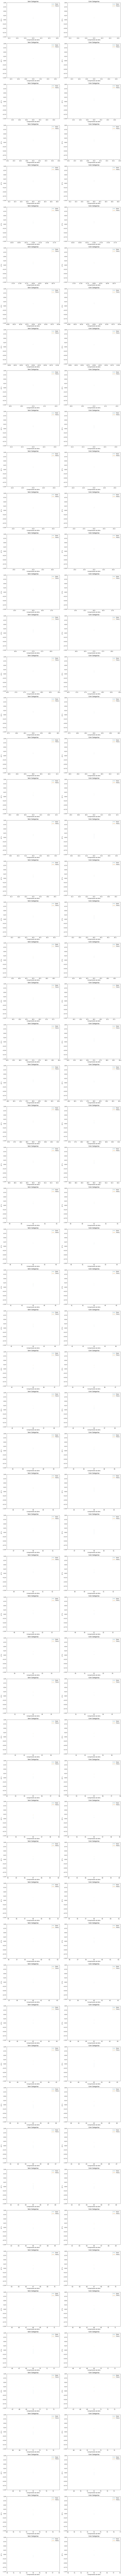

In [44]:
n = len(score)

fig, ax = plt.subplots(n, 2, figsize=(15, n*5))

for i in range(n):
    m = list(score.keys())[i]
    x_features = []
    y_train_mean = []
    y_train_std = []
    y_test_mean = []
    y_test_std = []

    for k in score[m]:
        x_features.append(k)
        y_train_mean.append(np.mean(score[m][k]['train']))
        y_train_std.append(np.std(score[m][k]['train']))
        y_test_mean.append(np.mean(score[m][k]['test']))
        y_test_std.append(np.std(score[m][k]['test']))

    x_features = np.asarray(x_features)
    y_train_mean = np.asarray(y_train_mean)
    y_train_std = np.asarray(y_train_std)
    y_test_mean = np.asarray(y_test_mean)
    y_test_std = np.asarray(y_test_std)

    if n == 1:
        ax[0].plot(x_features, y_test_mean, label='Teste', color='tab:blue')
        ax[0].fill_between(x_features, y_test_mean-y_test_std, y_test_mean+y_test_std, alpha=0.2, color='tab:blue')

        ax[0].plot(x_features, y_train_mean, label='Treino', color='tab:orange')
        ax[0].fill_between(x_features, y_train_mean-y_train_std, y_train_mean+y_train_std, alpha=0.2, color='tab:orange')

        ax[0].set_xlabel('Comprimento da Série')
        ax[0].set_ylabel('R^2')
        #ax[0].set_yscale('log')
        ax[0].set_ylim((-1, 1))
        ax[0].set_title('Sem Categorias')
        ax[0].legend(loc='best')
    
    else:
        ax[i][0].plot(x_features, y_test_mean, label='Teste', color='tab:blue')
        ax[i][0].fill_between(x_features, y_test_mean-y_test_std, y_test_mean+y_test_std, alpha=0.2, color='tab:blue')

        ax[i][0].plot(x_features, y_train_mean, label='Treino', color='tab:orange')
        ax[i][0].fill_between(x_features, y_train_mean-y_train_std, y_train_mean+y_train_std, alpha=0.2, color='tab:orange')

        ax[i][0].set_xlabel('Comprimento da Série')
        ax[i][0].set_ylabel('R^2')
        #ax[i][0].set_yscale('log')
        ax[i][0].set_ylim((-1, 1))
        ax[i][0].set_title('Sem Categorias')
        ax[i][0].legend(loc='best')


for i in range(n):
    m = list(score_cat.keys())[i]
    x_features = []
    y_train_mean = []
    y_train_std = []
    y_test_mean = []
    y_test_std = []

    for k in score_cat[m]:
        x_features.append(k)
        y_train_mean.append(np.mean(score_cat[m][k]['train']))
        y_train_std.append(np.std(score_cat[m][k]['train']))
        y_test_mean.append(np.mean(score_cat[m][k]['test']))
        y_test_std.append(np.std(score_cat[m][k]['test']))

    x_features = np.asarray(x_features)
    y_train_mean = np.asarray(y_train_mean)
    y_train_std = np.asarray(y_train_std)
    y_test_mean = np.asarray(y_test_mean)
    y_test_std = np.asarray(y_test_std)

    if n == 1:
        ax[1].plot(x_features, y_test_mean, label='Teste', color='tab:blue')
        ax[1].fill_between(x_features, y_test_mean-y_test_std, y_test_mean+y_test_std, alpha=0.2, color='tab:blue')

        ax[1].plot(x_features, y_train_mean, label='Treino', color='tab:orange')
        ax[1].fill_between(x_features, y_train_mean-y_train_std, y_train_mean+y_train_std, alpha=0.2, color='tab:orange')

        ax[1].set_xlabel('Comprimento da Série')
        ax[1].set_ylabel('R^2')
        #ax[1].set_yscale('log')
        ax[1].set_ylim((-1, 1))
        ax[1].set_title(f'Com Categorias')
        ax[1].legend(loc='best')

    else:
        ax[i][1].plot(x_features, y_test_mean, label='Teste', color='tab:blue')
        ax[i][1].fill_between(x_features, y_test_mean-y_test_std, y_test_mean+y_test_std, alpha=0.2, color='tab:blue')

        ax[i][1].plot(x_features, y_train_mean, label='Treino', color='tab:orange')
        ax[i][1].fill_between(x_features, y_train_mean-y_train_std, y_train_mean+y_train_std, alpha=0.2, color='tab:orange')

        ax[i][1].set_xlabel('Comprimento da Série')
        ax[i][1].set_ylabel('R^2')
        #ax[i][1].set_yscale('log')
        ax[i][1].set_ylim((-1, 1))
        ax[i][1].set_title(f'Com Categorias')
        ax[i][1].legend(loc='best')


plt.tight_layout()
plt.show()